In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import keras

In [ ]:
# Model Definition

# Modality Specific Module
class ModalitySpecificModule:
  @staticmethod
  def extract_modality_specific_interactions(input_layer):
    bi_gru_output = keras.layers.Bidirectional(keras.layers.GRU(64))(input_layer)
    msl_l1 = keras.layers.Dense(64, activation='relu')(bi_gru_output)
    msl_output = keras.layers.Dense(128, activation='relu')(msl_l1)
    return msl_output

  # Input Definition
  text_input = keras.Input(shape=(50, 300))
  audio_input = keras.Input(shape=(50, 5))
  visual_input = keras.Input(shape=(50, 20))

  @staticmethod
  def compute(text_input, audio_input, visual_input):
    # Extract Modality Specific Interactions
    text_msm_output = ModalitySpecificModule.extract_modality_specific_interactions(text_input)
    audio_msm_output = ModalitySpecificModule.extract_modality_specific_interactions(audio_input)
    visual_msm_output = ModalitySpecificModule.extract_modality_specific_interactions(visual_input)
    return text_msm_output, audio_msm_output, visual_msm_output


# Dense Multimodal Fusion Module
class DenseMultimodalFusionModule:
  residual_features = []
  @staticmethod
  def df_block(df_input1, df_input2, df_input3):
    df_output1 = keras.layers.Dense(128, activation='relu')(df_input1)
    df_output2 = keras.layers.Dense(128, activation='relu')(df_input2)
    df_output3 = keras.layers.Dense(128, activation='relu')(df_input3)
    return df_output1, df_output2, df_output3

  @staticmethod
  def dense_fusion_layer(f1, f2, f3):
    df_input1 = keras.layers.Concatenate()([f1, f3])
    df_input2 = keras.layers.Concatenate()([f1, f2])
    df_input3 = keras.layers.Concatenate()([f2, f3])
    r = tf.add(tf.add(f1, f2), f3)
    DenseMultimodalFusionModule.residual_features.append(r)
    fusion_output = DenseMultimodalFusionModule.df_block(df_input1, df_input2, df_input3)
    return fusion_output

  @staticmethod
  def compute(f1_0, f2_0, f3_0):
    f1_1, f2_1, f3_1 = DenseMultimodalFusionModule.dense_fusion_layer(f1_0, f2_0, f3_0)
    f1_2, f2_2, f3_2 = DenseMultimodalFusionModule.dense_fusion_layer(f1_1, f2_1, f3_1)
    f1_3, f2_3, f3_3 = DenseMultimodalFusionModule.dense_fusion_layer(f1_2, f2_2, f3_2)
    r = tf.add(tf.add(f1_3, f2_3), f3_3)
    DenseMultimodalFusionModule.residual_features.append(r)
    return DenseMultimodalFusionModule.residual_features


# Multimodal Residual Module
class MultimodalResidualModule:
  @staticmethod
  def compute(residual_features):
      final_residual_feature = residual_features[0]
      for r in residual_features[1:]:
          final_residual_feature = tf.add(final_residual_feature, r)
      return final_residual_feature


# Sentiment Classification Module
class SentimentClassificationModule:

  @staticmethod
  def convertLabels(label):
    result = 0
    if label < -2:
      result = -3
    elif -2 <= label and label < -1:
      result = -2
    elif -1 <= label and label < 0:
      result = -1
    elif 0 <= label and label <= 0:
      result = 0
    elif 0 < label and label <= 1:
      result = 1
    elif 1 < label and label <= 2:
      result = 2
    elif label > 2:
      result = 3

    rep = {
      -3 : [1., 0., 0., 0., 0., 0., 0.],
      -2 : [0., 1., 0., 0., 0., 0., 0.],
      -1 : [0., 0., 1., 0., 0., 0., 0.],
      0 : [0., 0., 0., 1., 0., 0., 0.],
      1 : [0., 0., 0., 0., 1., 0., 0.],
      2 : [0., 0., 0., 0., 0., 1., 0.],
      3 : [0., 0., 0., 0., 0., 0., 1.]
    }

    return tf.convert_to_tensor(rep[result])

  @staticmethod
  def compute(residual_feature):
    output_l1 = keras.layers.Dense(128, activation='relu')(residual_feature)
    output_l2 = keras.layers.Dense(64, activation='relu')(output_l1)
    output_l3 = keras.layers.Dense(32, activation='relu')(output_l2)
    output_l4 = keras.layers.Dense(16, activation='relu')(output_l3)

    num_classes = 7
    sentiment = keras.layers.Dense(num_classes, activation='softmax')(output_l4)
    return sentiment


text_input, audio_input, visual_input = ModalitySpecificModule.text_input, ModalitySpecificModule.audio_input, ModalitySpecificModule.visual_input
text_msm_output, audio_msm_output, visual_msm_output = ModalitySpecificModule.compute(text_input, audio_input, visual_input)
residual_features = DenseMultimodalFusionModule.compute(text_msm_output, audio_msm_output, visual_msm_output)
final_residual_feature = MultimodalResidualModule.compute(residual_features)
output = SentimentClassificationModule.compute(final_residual_feature)

model = keras.Model(inputs=[text_input, audio_input, visual_input], outputs=output)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 50, 300)]            0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 50, 5)]              0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 50, 20)]             0         []                            
                                                                                                  
 bidirectional_21 (Bidirect  (None, 128)                  140544    ['input_22[0][0]']            
 ional)                                                                                     

In [ ]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Multimodal Sentiment Analysis/mosi_data.pkl', 'rb') as fp:
  data = pickle.load(fp)

In [ ]:
print(data.keys())
print(data['train'].keys())
print(data['train']['vision'].shape)
print(data['train']['audio'].shape)
print(data['train']['text'].shape)
print(data['train']['labels'].shape)
print(data['train']['id'][0].shape)

dict_keys(['valid', 'test', 'train'])
dict_keys(['vision', 'labels', 'text', 'audio', 'id'])
(1284, 50, 20)
(1284, 50, 5)
(1284, 50, 300)
(1284, 1, 1)
(3,)


In [ ]:
def prepare_data(type):
  text_input = tf.convert_to_tensor(data[type]['text'])
  audio_input = tf.convert_to_tensor(data[type]['audio'])
  visual_input = tf.convert_to_tensor(data[type]['vision'])
  labels = [SentimentClassificationModule.convertLabels(element) for element in data[type]['labels'][:, 0][:, 0]]
  labels = np.array(labels, dtype=np.float32)
  return text_input, audio_input, visual_input, labels

train_text_input, train_audio_input, train_visual_input, train_labels = prepare_data('train')
valid_text_input, valid_audio_input, valid_visual_input, valid_labels = prepare_data('valid')

In [ ]:
type(train_labels)

numpy.ndarray

In [ ]:
training_dataset = [train_text_input, train_audio_input, train_visual_input]
validation_data = ([valid_text_input, valid_audio_input, valid_visual_input], valid_labels)

In [ ]:
epochs = 10
history = model.fit(training_dataset, train_labels, validation_data=validation_data, epochs=epochs)

Epoch 1/10
41/41 [==============================] - 26s 243ms/step - loss: 0.2344 - accuracy: 0.0000e+00 - val_loss: 0.2445 - val_accuracy: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 6s 146ms/step - loss: 0.2265 - accuracy: 0.0000e+00 - val_loss: 0.2287 - val_accuracy: 0.0000e+00
Epoch 3/10
41/41 [==============================] - 8s 186ms/step - loss: 0.2154 - accuracy: 0.0013 - val_loss: 0.2283 - val_accuracy: 0.0062
Epoch 4/10
41/41 [==============================] - 6s 147ms/step - loss: 0.2154 - accuracy: 0.0144 - val_loss: 0.2283 - val_accuracy: 0.0087
Epoch 5/10
41/41 [==============================] - 8s 185ms/step - loss: 0.2154 - accuracy: 0.0166 - val_loss: 0.2283 - val_accuracy: 0.0087
Epoch 6/10
41/41 [==============================] - 6s 156ms/step - loss: 0.2154 - accuracy: 0.0176 - val_loss: 0.2283 - val_accuracy: 0.0094
Epoch 7/10
41/41 [==============================] - 8s 193ms/step - loss: 0.2154 - accuracy: 0.0178 - val_loss: 0.2283 - val_accura

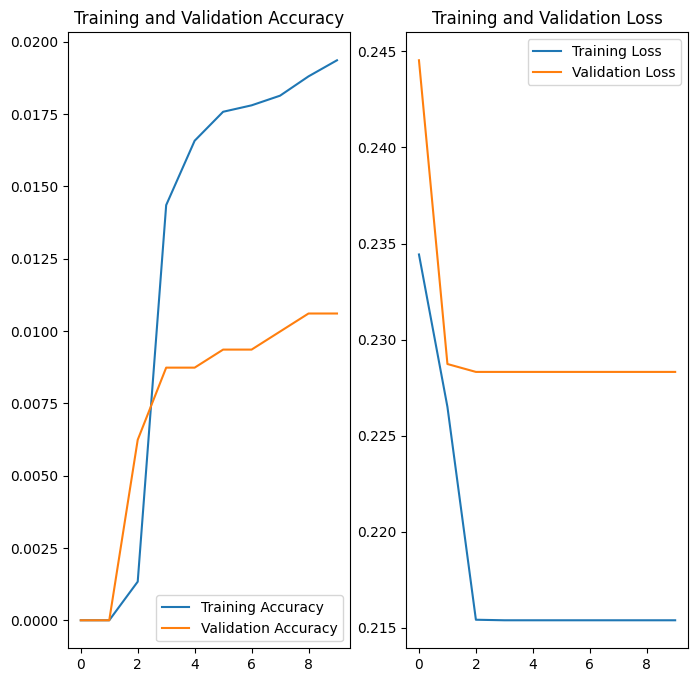

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_text_input, test_audio_input, test_visual_input, test_labels = prepare_data('test')
test_dataset = [test_text_input, test_audio_input, test_visual_input]

print("Evaluate on test data")
results = model.evaluate(test_dataset, test_labels)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 2s 101ms/step - loss: 0.2357 - accuracy: 0.0183
test loss, test acc: [0.23573511838912964, 0.018325697630643845]
